# Diffusion model

The primary goal of this assignment is to implement, train, and evaluate a Denoising Diffusion Probabilistic Model (DDPM) from scratch, enabling you to generate realistic images from the CIFAR-10 dataset.

Through this project, you will:

**Understand the diffusion paradigm**: Learn how images can be "diffused" into pure noise via a Markov chain and reversibly "denoised" to reconstruct or generate new samples.

**Implement key building blocks**: Construct a U-Net with time embeddings, residual blocks, and attention; define Gaussian diffusion schedules; and train via simple noise prediction loss.

**Explore variations**: Compare unconditional generation (diverse but unguided) with conditional generation using classifier-free guidance (CFG) for class-specific control.


> **Note:**  
> You will find a few **visualizations** throughout the assignment, these are included purely for **intuition building** and to help you better understand the underlying process.


# Diffusion Model Implementation - Grading Rubric (40 Points)

| Component | Points |
|-----------|--------|
| **ResidualBlock** | 6 |
| **AttentionBlock** | 6 |
| **Downsample** | 2 |
| **Upsample** | 2 |
| **UNet** | 8 |
| **GaussianDiffusion** | 8 |
| **train_unconditional** | 4 |
| **train_conditional** | 4 |
| **Total** | **40** |

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from einops import rearrange, reduce
import os
from torchvision.datasets import CIFAR10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


***Helper functions***

In [25]:
def plot_training_losses(train_losses, val_losses=None, save_path=None):

    plt.figure(figsize=(12, 5))
    epochs = range(1, len(train_losses) + 1)

    # Plot training loss
    plt.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=4, label='Train Loss')

    # Plot validation loss if provided
    if val_losses is not None:
        plt.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=4, label='Val Loss')

        # Highlight overfitting regions (where val > train significantly)
        for i in range(len(train_losses)):
            if val_losses[i] > train_losses[i] * 1.15:  # 15% threshold
                plt.axvspan(i+0.5, i+1.5, alpha=0.2, color='red')

    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')

    # Update title based on whether validation is included
    if val_losses is not None:
        plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    else:
        plt.title('Training Loss', fontsize=14, fontweight='bold')

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

def save_checkpoint(model, optimizer, epoch, loss, filepath):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filepath)
    print(f"Checkpoint saved to {filepath}")

def load_checkpoint(model, optimizer, filepath):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filepath} (Epoch {epoch}, Loss {loss:.4f})")
    return epoch, loss


def visualize_forward_diffusion(x_0, diffusion, timesteps_to_show=[0, 100, 200, 400, 600, 999],
                               save_path=None):
    """Show how an image gets corrupted by noise over time"""
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 4))

    for idx, t in enumerate(timesteps_to_show):
        t_tensor = torch.tensor([t], device=x_0.device)
        noisy_image = diffusion.q_sample(x_0, t_tensor)

        # Denormalize
        img = noisy_image[0].cpu() * 0.5 + 0.5
        img = torch.clamp(img, 0, 1)

        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].set_title(f't = {t}')
        axes[idx].axis('off')

    plt.suptitle('Forward Diffusion Process', fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


@torch.no_grad()
def visualize_reverse_diffusion(model, diffusion, shape, timesteps_to_show=[999, 600, 400, 200, 100, 0],
                               save_path=None):
    """Show how noise gradually becomes an image"""
    device = next(model.parameters()).device

    # Start from noise
    img = torch.randn(shape, device=device)

    images = {}

    for t_int in tqdm(reversed(range(0, diffusion.timesteps)), desc='Reverse diffusion'):
        t_tensor = torch.full((shape[0],), t_int, device=device, dtype=torch.long)
        img = diffusion.p_sample(model, img, t_tensor)

        if t_int in timesteps_to_show:
            images[t_int] = img.clone()

    # Plot
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 4))

    for idx, t_val in enumerate(timesteps_to_show):
        # Denormalize
        img_show = images[t_val][0].cpu() * 0.5 + 0.5
        img_show = torch.clamp(img_show, 0, 1)

        axes[idx].imshow(img_show.permute(1, 2, 0))
        axes[idx].set_title(f't = {t_val}')
        axes[idx].axis('off')

    plt.suptitle('Reverse Diffusion Process (Denoising)', fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

import torch
import torchvision
import matplotlib.pyplot as plt

CIFAR10_CLASSES = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_images(images, labels=None, nrow=8, save_path=None):
    """
    images: (B,C,H,W) tensor in [-1,1] or [0,1] (float) or [0,255] (uint8)
    """
    # Ensure shape
    assert images.ndim == 4 and images.shape[1] in (1,3), "Expect (B,C,H,W)"

    # Convert to float [0,1]
    if images.dtype == torch.uint8:
        imgs = images.float() / 255.0
    else:
        imgs = images.clone().float()
        # If looks like [-1,1], denormalize
        if imgs.min() < -0.1:
            imgs = imgs * 0.5 + 0.5

    imgs = imgs.clamp(0, 1)  # stay in displayable range

    # Build grid (set padding to white)
    grid = torchvision.utils.make_grid(
        imgs.cpu(), nrow=nrow, padding=2, pad_value=1.0
    )

    # Show with nearest interpolation to avoid blur
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu(), interpolation='nearest')
    plt.axis('off')

    if labels is not None:
        label_names = [CIFAR10_CLASSES[int(l)] for l in labels[:nrow]]
        plt.title(' | '.join(label_names))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=200)

    plt.show()


## Part 1: Data Loading and Preparation

In [3]:
def create_cifar_dataloaders(batch_size,num_workers=4):

    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scale to [-1, 1]
])

    train_dataset=CIFAR10(root="./cifar10_data",\
                        train=True,\
                        download=True,\
                        transform=transform
                        )
    test_dataset=CIFAR10(root="./cifar10_data",\
                        train=False,\
                        download=True,\
                        transform=transform
                        )

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers),\
            DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers)

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
train_dataloader,test_dataloader=create_cifar_dataloaders(batch_size=256)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


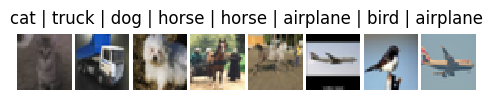

In [5]:
sample_images, sample_labels = next(iter(train_dataloader))
show_images(sample_images[:8], sample_labels[:8])

## Part 2: Understanding Noise and Corruption

Build intuition for the diffusion process by implementing a simple noise corruption function. Understand how images degrade under noise and why this degradation is reversible with the right model.


In this section, we introduce the **forward diffusion process**: gradually adding Gaussian noise to images over 1000 timesteps until they become pure noise. This creates a learnable "noising" chain that the model will reverse during generation.






In [6]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

### Key Components
- **`corrupt(x, amount)`**: A naive baseline, linearly mixes image `x` with uniform random noise based on `amount` (0=original, 1=full noise). Useful for contrast, but lacks probabilistic structure.
- **Noise Schedules**:
  - `linear_beta_schedule`: Linearly interpolates β (noise variance) from small (1e-4) to large (0.02), ensuring slow initial corruption.
  - `cosine_beta_schedule`: Smoother cosine-based curve (inspired by improved DDPMs), clipping extremes for numerical stability often yields better samples.
- **`SimpleDiffusion` Class**: Encapsulates the process. Precomputes α=1-β and cumulatives (√ᾱ_t, √(1-ᾱ_t)) for efficient `q_sample(x_start, t)`:  
  **q(x_t | x_0) = √ᾱ_t ⋅ x_0 + √(1-ᾱ_t) ⋅ ε** (ε ~ N(0,1)).  
  The `extract` helper broadcasts schedule values to batch/tensor shapes.
- **`compare_corruption_methods`**: Visualizes evolution over timesteps:  
  - **Row 1 (Green)**: Original image (reference).  
  - **Row 2 (Red)**: Naive linear corruption (destructs too fast).  
  - **Row 3 (Blue)**: DDPM forward (gradual, preserves structure longer).  


In [7]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    """Linear schedule for beta values"""
    return torch.linspace(beta_start, beta_end, timesteps)


def cosine_beta_schedule(timesteps, s=0.008):
    """Cosine schedule for beta values"""
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


class SimpleDiffusion:
    """Simple diffusion process for demonstration"""
    def __init__(self, timesteps=1000, beta_schedule='linear'):
        self.timesteps = timesteps


        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f"Unknown beta schedule: {beta_schedule}")


        self.betas = betas
        self.alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def extract(self, a, t, x_shape):
        """Extract values from array at indices t"""
        batch_size = t.shape[0]
        out = a.gather(0, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion: Add noise to x_start at timestep t"""
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [8]:
def compare_corruption_methods(x, num_steps=8):
    """
    Compare simple corruption vs DDPM forward diffusion with clear visual labels.

    Args:
        x: Input image tensor (batch_size, channels, height, width) in range [0, 1]
        num_steps: Number of timesteps to visualize

    Returns:
        matplotlib figure
    """


    x_normalized = x * 2 - 1  # Convert from [0, 1] to [-1, 1]

    # Initialize DDPM
    diffusion = SimpleDiffusion(timesteps=1000, beta_schedule='linear')

    # Create figure with more space for labels
    fig, axs = plt.subplots(3, num_steps, figsize=(18, 7))

    # Timesteps to visualize
    timesteps = np.linspace(0, 999, num_steps).astype(int)

    for idx, t in enumerate(timesteps):

        img = x[0].permute(1, 2, 0) if x.shape[1] == 3 else x[0, 0]
        img = torch.clamp(img, 0, 1)  # Ensure [0, 1] range
        axs[0, idx].imshow(img.cpu().numpy(), cmap='gray' if x.shape[1] == 1 else None)
        axs[0, idx].set_title(f't = {t}', fontsize=11, fontweight='bold')
        axs[0, idx].axis('off')


        for spine in axs[0, idx].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(3)
            spine.set_visible(True)


        amount = torch.tensor([t / 999.0]).view(1, 1, 1, 1)
        corrupted = corrupt(x, amount)
        img_corrupted = corrupted[0].permute(1, 2, 0) if x.shape[1] == 3 else corrupted[0, 0]
        img_corrupted = torch.clamp(img_corrupted, 0, 1)  # Ensure [0, 1] range
        axs[1, idx].imshow(img_corrupted.cpu().numpy(), cmap='gray' if x.shape[1] == 1 else None)
        axs[1, idx].axis('off')


        for spine in axs[1, idx].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
            spine.set_visible(True)


        t_tensor = torch.tensor([t])
        ddpm_noised = diffusion.q_sample(x_normalized, t_tensor)

        ddpm_noised = (ddpm_noised + 1) / 2
        ddpm_noised = torch.clamp(ddpm_noised, 0, 1)
        img_ddpm = ddpm_noised[0].permute(1, 2, 0) if x.shape[1] == 3 else ddpm_noised[0, 0]
        img_ddpm = torch.clamp(img_ddpm, 0, 1)  # Extra safety clamp
        axs[2, idx].imshow(img_ddpm.cpu().numpy(), cmap='gray' if x.shape[1] == 1 else None)
        axs[2, idx].axis('off')


        for spine in axs[2, idx].spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(3)
            spine.set_visible(True)


    axs[0, 0].text(-0.15, 0.5, 'ORIGINAL\nIMAGE',
                   transform=axs[0, 0].transAxes,
                   fontsize=14, fontweight='bold',
                   va='center', ha='right',
                   bbox=dict(boxstyle='round', facecolor='lightgreen',
                            edgecolor='green', linewidth=2, alpha=0.8))

    axs[1, 0].text(-0.15, 0.5, 'LINEAR\nCORRUPTION\n',
                   transform=axs[1, 0].transAxes,
                   fontsize=14, fontweight='bold',
                   va='center', ha='right',
                   bbox=dict(boxstyle='round', facecolor='lightcoral',
                            edgecolor='red', linewidth=2, alpha=0.8))

    axs[2, 0].text(-0.15, 0.5, 'DDPM\nDIFFUSION\n',
                   transform=axs[2, 0].transAxes,
                   fontsize=14, fontweight='bold',
                   va='center', ha='right',
                   bbox=dict(boxstyle='round', facecolor='lightblue',
                            edgecolor='blue', linewidth=2, alpha=0.8))


    fig.text(0.5, 0.98, 'Comparison: Linear Corruption vs DDPM Forward Diffusion',
             ha='center', fontsize=16, fontweight='bold')
    fig.text(0.5, 0.95, 'Time progression → (increasing noise from left to right)',
             ha='center', fontsize=12, style='italic', color='gray')

    plt.subplots_adjust(left=0.12, right=0.98, top=0.92, bottom=0.02,
                       hspace=0.15, wspace=0.05)
    return fig


Batch shape: torch.Size([256, 3, 32, 32])

[2] Creating side-by-side comparison...


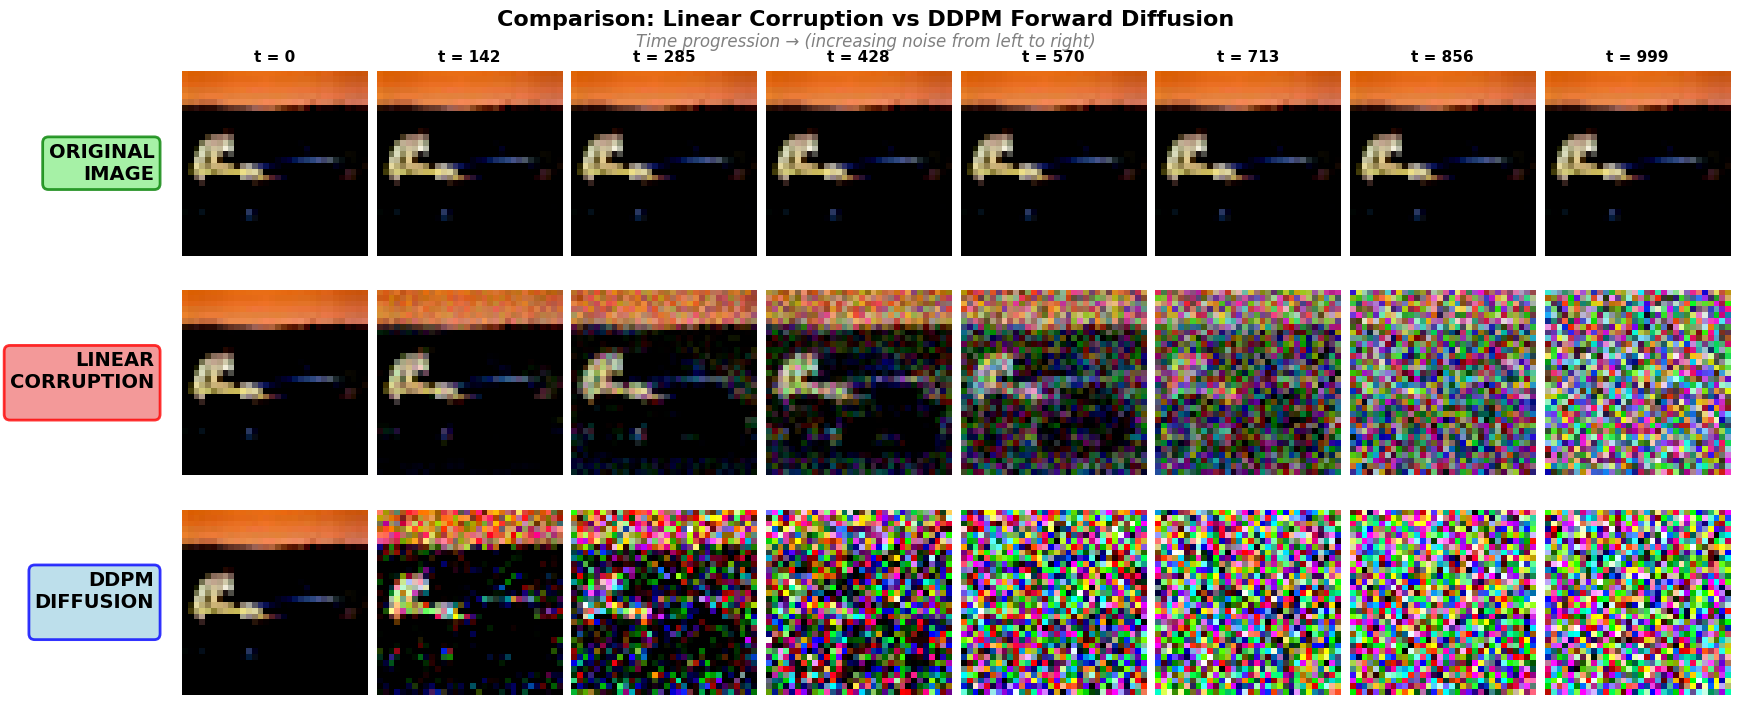

In [9]:
batch_x, batch_y = next(iter(train_dataloader))
print(f"Batch shape: {batch_x.shape}")

x = batch_x[0:1]

print("\n[2] Creating side-by-side comparison...")
fig1 = compare_corruption_methods(x, num_steps=8)
plt.show()



### Key takeaways
This illustrates why scheduled noise is crucial: It ensures the reverse process (denoising) is tractable, unlike uniform mixing. Run the code to see noise build left-to-right, expect DDPM row to retain faint outlines at high t, unlike the red row's chaos.

# part 3. U-Net Architecture

Build  U-Net architecture that serves as the noise prediction backbone of your diffusion model. This network must learn to predict the noise component in images across all noise levels and (optionally) all object classes.

The denoising model needs to know how noisy the input image is.

At t=0 (clean image) → apply light denoising

At t=500 (medium noise) → apply moderate denoising

At t=999 (pure noise) → apply heavy denoising

Convert the timestep integer (0-999) into a rich vector representation that the  network can understand.


Why Sinusoidal?

 Fixed function - no parameters to learn

 Smooth - nearby timesteps (t=500, t=501) have similar embeddings

 Rich - uses multiple frequencies to capture patterns at different scales

 Proven - same technique used in Transformers



In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal positional embeddings for timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



#Need to fill

Implement a residual-style block that conditions on a timestep

ResidualBlock combines two convolution blocks with skip connections and time embedding injection, allowing deep networks to learn denoising at different noise levels while maintaining stable gradient flow.

In [11]:
class ResidualBlock(nn.Module):
    """Basic residual block with time embedding
     Tips:
    - you may follow this general structure: Norm → Activation → Conv → (add time) → Norm → Activation → Dropout → Conv → Residual Add.
    - Keep spatial size constant by using padding=1 in 3×3 convs.
    - Use SiLU (same as Swish) for activation.
    - GroupNorm is more stable than BatchNorm for small batches.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
        self.conv2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_emb):
        h = self.conv1(x)
        h += self.time_proj(time_emb)[:, :, None, None]
        h = self.conv2(h)
        return h + self.residual_conv(x)

#Need to fill



Convolutional layers only look at local neighborhoods ( 3×3 pixels). They can't directly relate distant parts of an image.


Self-attention allows every pixel to look at every other pixel, capturing long-range dependencies. In Diffusion Models, Attention helps maintain global coherence ensures generated images have consistent structure and appearance throughout.

In [12]:
class AttentionBlock(nn.Module):
    """Self-attention block"""
    def __init__(self, channels, num_heads=8):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5
        inner_dim = self.head_dim * self.num_heads # Should be equal to channels

        self.norm = nn.GroupNorm(8, channels) # Using 8 groups, channels as input
        # 1x1 conv to project input to query, key, and value
        self.to_qkv = nn.Conv2d(channels, inner_dim * 3, 1, bias=False)
        # 1x1 conv for output projection after attention
        self.to_out = nn.Conv2d(inner_dim, channels, 1)

    def forward(self, x):
        shortcut = x # Save original input for residual connection
        h_spatial, w_spatial = x.shape[-2:] # Store original spatial dimensions

        # Apply GroupNormalization
        normed_x = self.norm(x)

        # Project to Q, K, V using 1x1 convolution
        # Output is (batch, 3 * channels, H, W), then split into 3 tensors
        qkv = self.to_qkv(normed_x).chunk(3, dim=1)

        # Rearrange for multi-head attention:
        # From (batch, channels, H, W) to (batch, heads, (H*W), head_dim)
        # 'b (h d) x y -> b h (x y) d' where h=num_heads, d=head_dim, x=H, y=W
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h = self.num_heads), qkv)

        # Compute attention scores: Q @ K_transpose / sqrt(head_dim)
        # (batch, heads, N, head_dim) @ (batch, heads, head_dim, N) -> (batch, heads, N, N)
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # Apply attention to value: Attention_weights @ V
        # (batch, heads, N, N) @ (batch, heads, N, head_dim) -> (batch, heads, N, head_dim)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)

        # Rearrange back to original (batch, channels, H, W) format
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h_spatial, y = w_spatial)

        # Apply final 1x1 convolution
        out = self.to_out(out)

        # Add residual connection
        return out + shortcut

In [13]:
class Downsample(nn.Module):
    """Downsample block"""
    """Reduces spatial resolution by 2× (i.e., 32×32 → 16×16) using strided convolution
    to compress features as we go deeper in the U-Net encoder."""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class Upsample(nn.Module):
    """Upsample block"""
    """Increases spatial resolution by 2× (i.e.,16×16 → 32×32) using interpolation + convolution
    to expand features as we go up in the U-Net decoder."""
    def __init__(self, channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsample(x)
        return self.conv(x)

#Gather together (Need to Fill)




**Goal:** Build a diffusion U-Net that takes an image, a timestep, and optionally a class label, then predicts noise.

**Input and output**
The model takes:

* `x`: an image tensor
* `t`: a tensor of timesteps
* `y`: optional class labels


---

**Time and class embeddings**

1. Convert each timestep into a sinusoidal embedding.
2. Pass it through two Linear layers with a SiLU activation in between to form the final time embedding.
3. If the model is conditional, look up a class embedding and add it to the time embedding.

---

**Residual block**
Each block has two 3×3 convolution layers.

* Normalize, activate, and convolve.
* Add the projected time embedding to the feature map.
* Normalize, activate, apply dropout, and convolve again.
* Add a shortcut connection (either identity or 1×1 convolution if channels differ).

---

**Attention block**
Applies self-attention over the spatial positions.

* Compute query, key, and value from the feature map using a 1×1 convolution.
* Split into multiple heads and perform scaled dot-product attention.
* Project back and add the result to the original feature map.

---

**U-Net structure**


1. **Encoder:** several stages of residual blocks, followed by downsampling. Save outputs for skip connections.
2. **Middle:** a residual block, an attention block, and another residual block.
3. **Decoder:** concatenate skip features, apply residual blocks, then upsample.


---




In [15]:
class UNet(nn.Module):
    """U-Net architecture for diffusion models"""
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        base_channels=128,
        channel_mult=(1, 2, 2, 2),
        num_res_blocks=2,
        time_emb_dim=512,
        num_classes=None,  # None for unconditional, 10 for CIFAR-10 conditional
        dropout=0.1
    ):
        super().__init__()

        self.num_classes = num_classes
        self.num_res_blocks = num_res_blocks

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Class embedding
        if num_classes is not None:
            self.class_emb = nn.Embedding(num_classes + 1, time_emb_dim) # +1 for unconditional token

        # Initial convolution
        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        channels = [base_channels * mult for mult in channel_mult]
        in_out_channels = [(base_channels, channels[0])] + list(zip(channels[:-1], channels[1:]))

        # Track where attention blocks should be placed
        attn_channels = [True if mult >= 2 else False for mult in channel_mult]

        # Encoder
        for i, (ch_in, ch_out) in enumerate(in_out_channels):
            is_attn = attn_channels[i]
            for _ in range(num_res_blocks):
                self.downs.append(ResidualBlock(ch_in, ch_out, time_emb_dim, dropout))
                ch_in = ch_out
            if is_attn:
                self.downs.append(AttentionBlock(ch_out))
            if i < len(channel_mult) - 1:
                self.downs.append(Downsample(ch_out))

        # Middle block
        mid_channels = channels[-1]
        self.mid_block1 = ResidualBlock(mid_channels, mid_channels, time_emb_dim, dropout)
        self.mid_attn = AttentionBlock(mid_channels)
        self.mid_block2 = ResidualBlock(mid_channels, mid_channels, time_emb_dim, dropout)

        # Decoder
        for i, (ch_in, ch_out) in enumerate(reversed(in_out_channels)):
            is_attn = attn_channels[len(channel_mult) - 1 - i]
            for j in range(num_res_blocks):
                # First ResBlock at each stage concatenates with skip (input = ch_out*2)
                # Subsequent ResBlocks don't concatenate (input = ch_in)
                if j == 0:
                    self.ups.append(ResidualBlock(ch_out * 2, ch_in, time_emb_dim, dropout))
                else:
                    self.ups.append(ResidualBlock(ch_in, ch_in, time_emb_dim, dropout))
            if is_attn:
                self.ups.append(AttentionBlock(ch_in))
            if i < len(channel_mult) - 1:
                self.ups.append(Upsample(ch_in))

        # Final convolution
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1)
        )


    def forward(self, x, time, y=None):
        # Time embeddings
        time_emb = self.time_mlp(time)

        # Class embeddings (if conditional)
        if self.num_classes is not None and y is not None:
            class_emb = self.class_emb(y)
            time_emb = time_emb + class_emb

        h = self.initial_conv(x)
        skips = []

        # Encoder: save skip connection before each downsample
        for layer in self.downs:
            if isinstance(layer, ResidualBlock):
                h = layer(h, time_emb)
            elif isinstance(layer, AttentionBlock):
                h = layer(h)
            else: # Downsample
                skips.append(h)  # Save BEFORE downsampling
                h = layer(h)

        # Save the final encoder output (before middle block)
        skips.append(h)

        # Middle block
        h = self.mid_block1(h, time_emb)
        h = self.mid_attn(h)
        h = self.mid_block2(h, time_emb)

        # Decoder: concatenate skip for first ResBlock of each stage
        stage_res_count = 0
        for layer in self.ups:
            if isinstance(layer, ResidualBlock):
                # First ResBlock in each stage concatenates with skip
                if stage_res_count == 0:
                    h = torch.cat([h, skips.pop()], dim=1)
                h = layer(h, time_emb)
                stage_res_count += 1
            elif isinstance(layer, AttentionBlock):
                h = layer(h)
            else: # Upsample
                h = layer(h)
                stage_res_count = 0  # Reset counter for next stage

        return self.final_conv(h)

# PART 4: DIFFUSION PROCESS

linear_beta_schedule: Returns betas that increase linearly from beta_start to beta_end across timesteps.

cosine_beta_schedule: Returns betas from a cosine cumulative alpha schedule for a smoother noise ramp that often samples better.

In [16]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    """Linear schedule for beta values"""
    return torch.linspace(beta_start, beta_end, timesteps)


def cosine_beta_schedule(timesteps, s=0.008):
    """Cosine schedule for beta values (often works better)"""
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

#Need to Fill


We need a mathematical framework to:

Forward Process: Gradually add noise to images (training data generation)
Reverse Process: Gradually remove noise from pure noise (image generation)
Training: Teach the model to predict and remove noise at any timestep.



GaussianDiffusion implements the DDPM (Denoising Diffusion Probabilistic Models) algorithm that defines:

How much noise to add at each timestep (noise schedule)
How to sample noisy images at any timestep t (forward diffusion)
How to denoise step-by-step (reverse diffusion)
Loss function for training the model


---


DDIM sampling is a **faster, deterministic version** of the standard DDPM sampling process.

- It reuses the same trained diffusion model but **skips multiple timesteps** using a fixed stride schedule.  
- Each step directly computes \( x_{t-1} \) from \( x_t \) and the model’s predicted noise, **avoiding random sampling** unless a noise factor (`eta > 0`) is added.  
- When `eta = 0`, the process becomes **deterministic** (same output every time).  
- This allows generation in **far fewer steps** (i.e., 50 instead of 1000) while maintaining similar image quality.

---


In [23]:
class GaussianDiffusion:
    """Gaussian Diffusion Process for DDPM"""
    def __init__(self, timesteps=1000, beta_schedule='linear', device="cpu"):
        self.timesteps = timesteps
        self.device = device

        # Define beta schedule
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f"Unknown beta schedule: {beta_schedule}")

        # Pre-calculate useful values and move to device
        self.betas = betas.to(self.device)
        self.alphas = (1.0 - betas).to(self.device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(self.device)

        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod).to(self.device)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod).to(self.device)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)).to(self.device)
        self.posterior_log_variance_clipped = torch.log(torch.clamp(self.posterior_variance, min=1e-20)).to(self.device)
        self.posterior_mean_coef1 = (self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)).to(self.device)
        self.posterior_mean_coef2 = ((1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)).to(self.device)

    def extract(self, a, t, x_shape):
        """Extract values from array a at indices t and reshape to match x_shape"""
        batch_size = t.shape[0]
        out = a.gather(0, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion: Add noise to x_start at timestep t"""
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t.to(self.device), x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(
            self.sqrt_one_minus_alphas_cumprod, t.to(self.device), x_start.shape
        )

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def predict_start_from_noise(self, x_t, t, noise):
        """Predict x_0 from x_t and predicted noise"""
        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t.to(self.device), x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(
            self.sqrt_one_minus_alphas_cumprod, t.to(self.device), x_t.shape
        )
        return (x_t - sqrt_one_minus_alphas_cumprod_t * noise) / sqrt_alphas_cumprod_t

    def q_posterior(self, x_start, x_t, t):
        """Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0)"""
        posterior_mean_coef1_t = self.extract(self.posterior_mean_coef1, t.to(self.device), x_t.shape)
        posterior_mean_coef2_t = self.extract(self.posterior_mean_coef2, t.to(self.device), x_t.shape)
        posterior_mean = posterior_mean_coef1_t * x_start + posterior_mean_coef2_t * x_t
        posterior_variance_t = self.extract(self.posterior_variance, t.to(self.device), x_t.shape)
        posterior_log_variance_clipped_t = self.extract(self.posterior_log_variance_clipped, t.to(self.device), x_t.shape)
        return posterior_mean, posterior_variance_t, posterior_log_variance_clipped_t

    def p_mean_variance(self, model, x_t, t, y=None, clip_denoised=True):
        """Compute mean and variance of model distribution p(x_{t-1} | x_t)"""
        predicted_noise = model(x_t, t, y)
        x_start = self.predict_start_from_noise(x_t, t, predicted_noise)

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        mean, variance, log_variance = self.q_posterior(x_start, x_t, t)
        return mean, variance, log_variance, x_start

    @torch.no_grad()
    def p_sample(self, model, x_t, t, y=None):
        """Sample x_{t-1} from model distribution p(x_{t-1} | x_t)"""
        # t is already a tensor of shape (batch_size,) from visualize_reverse_diffusion
        mean, _, log_variance, _ = self.p_mean_variance(model, x_t, t, y=y)
        # Check the first element of the tensor t for the condition
        noise = torch.randn_like(x_t) if t[0] > 0 else 0.
        return mean + (0.5 * log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, model, shape, y=None):
        """Generate samples by iteratively denoising (DDPM sampling)"""
        img = torch.randn(shape, device=next(model.parameters()).device)

        for i in tqdm(reversed(range(0, self.timesteps)), desc='DDPM Sampling', total=self.timesteps):
            # Create a tensor for the current timestep for all elements in the batch
            t_tensor = torch.full((shape[0],), i, device=img.device, dtype=torch.long)
            img = self.p_sample(model, img, t_tensor, y)
        return img

    @torch.no_grad()
    def ddim_sample(self, model, shape, y=None, ddim_timesteps=50, eta=0.0):
        """Generate samples using DDIM (Generates images using only 50 steps instead of 1000 by skipping timesteps,
    making sampling 20\u00d7 faster while maintaining quality)"""
        device = next(model.parameters()).device
        b = shape[0]

        # DDIM sampling requires a different timestep schedule
        c = self.timesteps // ddim_timesteps
        ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        ddim_timestep_seq = ddim_timestep_seq + 1 # make sure to include the last timestep
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='DDIM Sampling', total=ddim_timesteps):
            t = torch.full((b,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((b,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # Predict noise using the model
            pred_noise = model(img, t, y)

            # Calculate x_0 prediction
            alpha_cumprod_t = self.extract(self.alphas_cumprod, t, img.shape)
            sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, img.shape)
            pred_x0 = (img - sqrt_one_minus_alphas_cumprod_t * pred_noise) / torch.sqrt(alpha_cumprod_t)
            pred_x0.clamp_(-1., 1.)

            # Calculate x_{prev_t} for DDIM
            alpha_cumprod_prev_t = self.extract(self.alphas_cumprod, prev_t, img.shape)

            variance = self.betas[t[0]] * (1. - alpha_cumprod_prev_t) / (1. - alpha_cumprod_t)
            std_dev_t = eta * torch.sqrt(variance)

            mean_x_t_minus_1 = torch.sqrt(alpha_cumprod_prev_t) * pred_x0
            if prev_t[0] > 0:
                mean_x_t_minus_1 += torch.sqrt(1. - alpha_cumprod_prev_t - std_dev_t**2) * pred_noise

            img = mean_x_t_minus_1 + std_dev_t * torch.randn_like(img) if prev_t[0] > 0 else mean_x_t_minus_1

        return img

    def training_losses(self, model, x_start, t, y=None):
        """Compute training loss (simple MSE loss on predicted noise)"""
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, y)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

# PART 5: TRAINING FUNCTIONS (Need to Fill)


whilr training, sample couple of images per epoch. This helps to visualize how the noise is getting shaped!!!

In [18]:
def train_unconditional(model, diffusion, train_loader, test_loader, num_epochs=50, lr=2e-4,
                       save_dir='./checkpoints'):
    """Train unconditional diffusion model"""
    """
    Unconditional DDPM training:
    - For each batch: pick random t, compute diffusion MSE loss, step optimizer.
    - Validate with the same loss on random t.
    - Periodically sample images with DDIM and save a checkpoint.
    """
    #Need to fill
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    os.makedirs(save_dir, exist_ok=True)

    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for step, (batch, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            optimizer.zero_grad()
            batch_size = batch.shape[0]
            batch = batch.to(device)

            # Sample a random timestep for each image in the batch
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

            loss = diffusion.training_losses(model, batch, t)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for step, (batch, _) in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1} Validation")):
                batch_size = batch.shape[0]
                batch = batch.to(device)
                t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
                loss = diffusion.training_losses(model, batch, t)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Save a checkpoint and sample images periodically
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            save_checkpoint(model, optimizer, epoch + 1, avg_loss, os.path.join(save_dir, f'unconditional_ckpt_epoch_{epoch+1}.pt'))

            # Generate samples for visualization
            model.eval()
            with torch.no_grad():
                samples = diffusion.ddim_sample(model, (16, 3, 32, 32), ddim_timesteps=50)
                show_images(samples, nrow=4, save_path=os.path.join(save_dir, f'unconditional_samples_epoch_{epoch+1}.png'))

    return losses, val_losses

#### Same as unconditional, but drop labels with prob p_uncond so the model learns both conditional and unconditional modes for CFG at sampling.

In [19]:
def train_conditional(model, diffusion, train_loader, test_loader, num_epochs=50, lr=2e-4,
                     p_uncond=0.1, save_dir='./checkpoints_conditional'):
    """
    Train conditional diffusion model with classifier-free guidance.
    Args:
        p_uncond: Probability of dropping class labels (for classifier-free guidance)
    """
    """
    Train conditional diffusion with classifier-free guidance (CFG).
    - Randomly replace labels with UNCOND_ID with prob p_uncond.
    - Optimize MSE on predicted noise.
    - Periodically sample per-class with CFG.

    """
    #Need to fill
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    os.makedirs(save_dir, exist_ok=True)

    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for step, (batch, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            optimizer.zero_grad()
            batch_size = batch.shape[0]
            batch = batch.to(device)
            labels = labels.to(device)

            # Randomly drop labels for classifier-free guidance
            unconditional_mask = torch.rand(batch_size, device=device) < p_uncond
            labels_conditional = labels.clone()
            labels_conditional[unconditional_mask] = model.num_classes # Use special token for unconditional

            # Sample a random timestep for each image in the batch
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

            loss = diffusion.training_losses(model, batch, t, y=labels_conditional)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for step, (batch, labels) in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1} Validation")):
                batch_size = batch.shape[0]
                batch = batch.to(device)
                labels = labels.to(device)

                # For validation, we typically don't drop labels randomly for loss calculation
                # or we can use the same p_uncond for consistency with training. Let's use full labels.
                t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
                loss = diffusion.training_losses(model, batch, t, y=labels)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Save a checkpoint and sample images periodically
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            save_checkpoint(model, optimizer, epoch + 1, avg_loss, os.path.join(save_dir, f'conditional_ckpt_epoch_{epoch+1}.pt'))

            # Generate samples for visualization with CFG
            model.eval()
            with torch.no_grad():
                # Generate 16 images for each class (10 classes in CIFAR-10)
                # For a more compact visualization, let's just generate a few from each class
                num_samples_per_class = 1
                y_sample = torch.arange(model.num_classes, device=device).repeat(num_samples_per_class)
                # Reshape y_sample to match batch_size for sample_with_cfg, e.g., 10 samples for 10 classes
                # For CIFAR10, 10 classes, so we can generate one per class initially, then expand if needed
                sample_shape = (model.num_classes * num_samples_per_class, 3, 32, 32)

                print(f"\nGenerating conditional samples for epoch {epoch+1}...")
                for guidance_scale_vis in [3.0]: # Use a fixed guidance scale for epoch visualization
                    samples = sample_with_cfg(
                        model,
                        diffusion,
                        sample_shape,
                        y_sample,
                        guidance_scale=guidance_scale_vis,
                        ddim_timesteps=50
                    )
                    show_images(samples, labels=y_sample, nrow=model.num_classes,
                                save_path=os.path.join(save_dir, f'conditional_samples_epoch_{epoch+1}_cfg_{guidance_scale_vis}.png'))

    return losses, val_losses

#PART 6: CLASSIFIER-FREE GUIDANCE SAMPLING


Generates images using Classifier-Free Guidance (CFG), which strengthens class conditioning by blending conditional and unconditional predictions to produce higher-quality, class-specific images in just 50 steps instead of 1000

In [20]:
def sample_with_cfg(model, diffusion, shape, y, guidance_scale=3.0, ddim_timesteps=50):
    """
    Sample with Classifier-Free Guidance.

    Args:
        guidance_scale: Higher values = stronger conditioning (typical range: 1-10)
    """
    device = next(model.parameters()).device
    batch_size = shape[0]

    # Create DDIM timestep schedule
    c = diffusion.timesteps // ddim_timesteps
    ddim_timestep_seq = np.asarray(list(range(0, diffusion.timesteps, c)))
    ddim_timestep_seq = ddim_timestep_seq + 1
    ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

    # Start from pure noise
    img = torch.randn(shape, device=device)

    # Unconditional class index
    y_uncond = torch.full_like(y, model.num_classes)  # Use the special token for unconditional

    for i in tqdm(reversed(range(0, ddim_timesteps)), desc='CFG Sampling', total=ddim_timesteps):
        t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
        t_prev = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

        # Predict noise with and without conditioning
        pred_noise_cond = model(img, t, y)
        pred_noise_uncond = model(img, t, y_uncond)

        # Apply classifier-free guidance
        pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

        # Predict x_0
        alpha_cumprod_t = diffusion.extract(diffusion.alphas_cumprod, t, img.shape)
        alpha_cumprod_t_prev = diffusion.extract(diffusion.alphas_cumprod, t_prev, img.shape)

        pred_x0 = (img - torch.sqrt(1 - alpha_cumprod_t) * pred_noise) / torch.sqrt(alpha_cumprod_t)
        pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)

        # Compute direction pointing to x_t
        dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev) * pred_noise

        # Compute x_{t-1}
        img = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + dir_xt

    return img

#Main execution

> **Note:**  
> The default setting uses a **linear noise schedule**, but you’re encouraged to experiment with a **cosine schedule** as well for potentially smoother results.

---

###  Observability Check
Sampling images **after each epoch** helps visualize training progress.  
In the **initial epochs**, the outputs may appear incoherent, but as training continues, the images **gradually become clearer**.  
If time allows, try **increasing the number of epochs** to observe a more complete denoising progression.



TRAINING UNCONDITIONAL MODEL

[2] Initializing unconditional model...
Model Parameters: 24.4M

[3] Training unconditional model...


Epoch 1 Validation: 100%|██████████| 40/40 [00:02<00:00, 18.70it/s]


Epoch 1: Train Loss = 0.1284, Val Loss = 0.0548


Epoch 2 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


Epoch 2: Train Loss = 0.0561, Val Loss = 0.0454


Epoch 3 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s]


Epoch 3: Train Loss = 0.0482, Val Loss = 0.0443


Epoch 4 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 4: Train Loss = 0.0438, Val Loss = 0.0401


Epoch 5 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s]


Epoch 5: Train Loss = 0.0416, Val Loss = 0.0396


Epoch 6 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.77it/s]


Epoch 6: Train Loss = 0.0414, Val Loss = 0.0370


Epoch 7 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 7: Train Loss = 0.0392, Val Loss = 0.0363


Epoch 8 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.76it/s]


Epoch 8: Train Loss = 0.0382, Val Loss = 0.0370


Epoch 9 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.74it/s]


Epoch 9: Train Loss = 0.0377, Val Loss = 0.0348


Epoch 10 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


Epoch 10: Train Loss = 0.0366, Val Loss = 0.0336
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_10.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 59.40it/s]


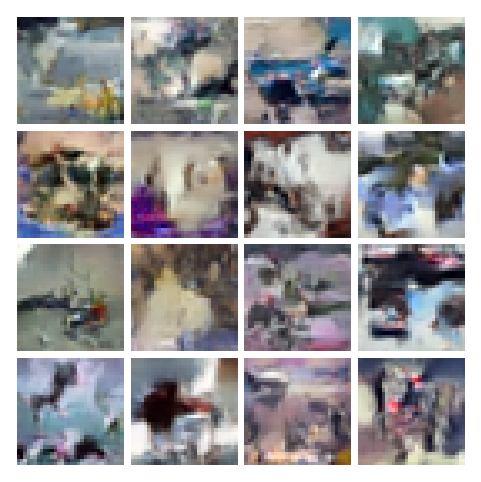

Epoch 11 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 11: Train Loss = 0.0370, Val Loss = 0.0346


Epoch 12 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 12: Train Loss = 0.0353, Val Loss = 0.0354


Epoch 13 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 13: Train Loss = 0.0352, Val Loss = 0.0340


Epoch 14 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 14: Train Loss = 0.0352, Val Loss = 0.0344


Epoch 15 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 15: Train Loss = 0.0350, Val Loss = 0.0331


Epoch 16 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


Epoch 16: Train Loss = 0.0339, Val Loss = 0.0323


Epoch 17 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 17: Train Loss = 0.0350, Val Loss = 0.0334


Epoch 18 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 18: Train Loss = 0.0342, Val Loss = 0.0322


Epoch 19 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 19: Train Loss = 0.0338, Val Loss = 0.0339


Epoch 20 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 20: Train Loss = 0.0340, Val Loss = 0.0338
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_20.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.82it/s]


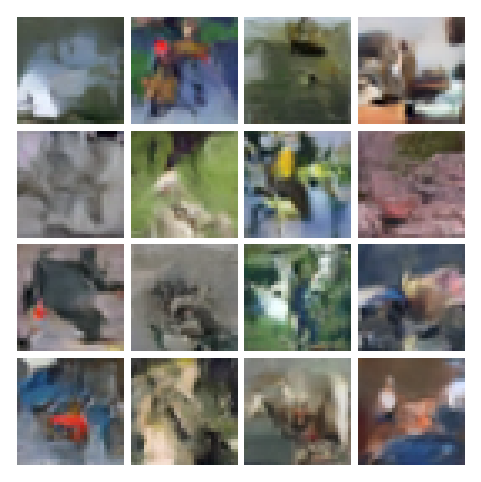

Epoch 21 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 21: Train Loss = 0.0335, Val Loss = 0.0336


Epoch 22 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 22: Train Loss = 0.0334, Val Loss = 0.0329


Epoch 23 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 23: Train Loss = 0.0338, Val Loss = 0.0333


Epoch 24 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 24: Train Loss = 0.0332, Val Loss = 0.0323


Epoch 25 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 25: Train Loss = 0.0325, Val Loss = 0.0311


Epoch 26 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 26: Train Loss = 0.0332, Val Loss = 0.0330


Epoch 27 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 27: Train Loss = 0.0330, Val Loss = 0.0320


Epoch 28 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 28: Train Loss = 0.0330, Val Loss = 0.0325


Epoch 29 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 29: Train Loss = 0.0330, Val Loss = 0.0323


Epoch 30 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 30: Train Loss = 0.0327, Val Loss = 0.0329
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_30.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.77it/s]


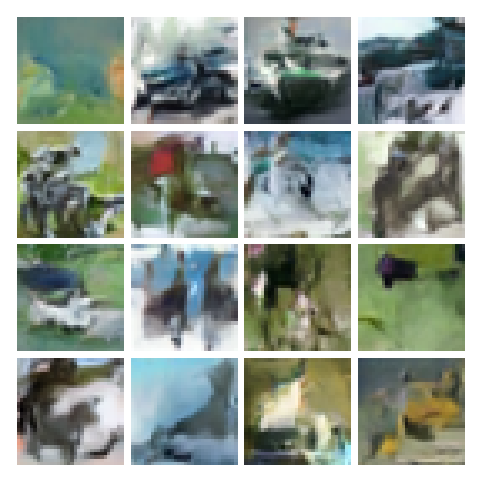

Epoch 31 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 31: Train Loss = 0.0328, Val Loss = 0.0326


Epoch 32 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 32: Train Loss = 0.0324, Val Loss = 0.0344


Epoch 33 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 33: Train Loss = 0.0326, Val Loss = 0.0302


Epoch 34 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 34: Train Loss = 0.0324, Val Loss = 0.0312


Epoch 35 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 35: Train Loss = 0.0320, Val Loss = 0.0320


Epoch 36 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 36: Train Loss = 0.0324, Val Loss = 0.0311


Epoch 37 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 37: Train Loss = 0.0321, Val Loss = 0.0318


Epoch 38 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.71it/s]


Epoch 38: Train Loss = 0.0320, Val Loss = 0.0310


Epoch 39 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 39: Train Loss = 0.0323, Val Loss = 0.0306


Epoch 40 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 40: Train Loss = 0.0325, Val Loss = 0.0317
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_40.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.25it/s]


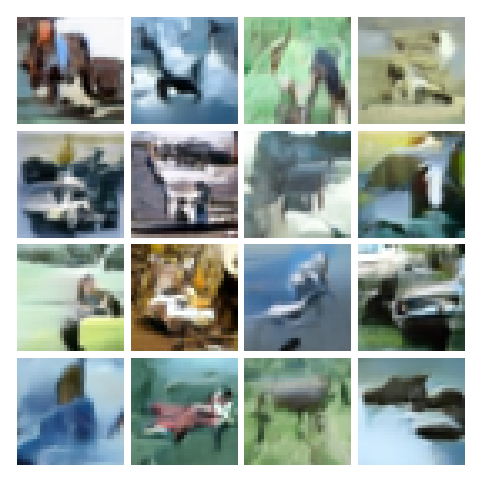

Epoch 41 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 41: Train Loss = 0.0322, Val Loss = 0.0316


Epoch 42 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 42: Train Loss = 0.0317, Val Loss = 0.0323


Epoch 43 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 43: Train Loss = 0.0317, Val Loss = 0.0312


Epoch 44 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 44: Train Loss = 0.0322, Val Loss = 0.0330


Epoch 45 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 45: Train Loss = 0.0320, Val Loss = 0.0309


Epoch 46 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 46: Train Loss = 0.0322, Val Loss = 0.0312


Epoch 47 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


Epoch 47: Train Loss = 0.0315, Val Loss = 0.0317


Epoch 48 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 48: Train Loss = 0.0320, Val Loss = 0.0309


Epoch 49 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 49: Train Loss = 0.0319, Val Loss = 0.0337


Epoch 50 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s]


Epoch 50: Train Loss = 0.0320, Val Loss = 0.0319
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_50.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.22it/s]


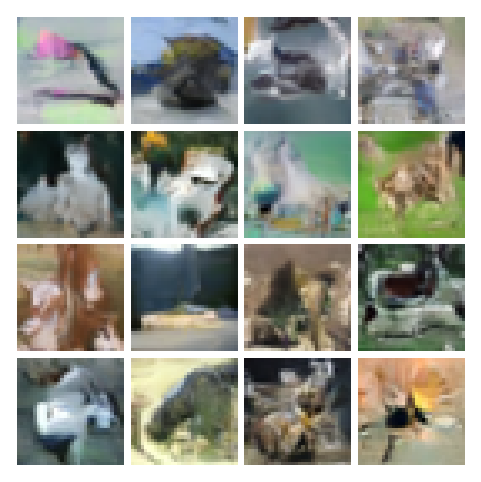

Epoch 51 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 51: Train Loss = 0.0309, Val Loss = 0.0302


Epoch 52 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 52: Train Loss = 0.0310, Val Loss = 0.0315


Epoch 53 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 53: Train Loss = 0.0318, Val Loss = 0.0305


Epoch 54 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 54: Train Loss = 0.0314, Val Loss = 0.0305


Epoch 55 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 55: Train Loss = 0.0314, Val Loss = 0.0332


Epoch 56 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 56: Train Loss = 0.0311, Val Loss = 0.0303


Epoch 57 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 57: Train Loss = 0.0311, Val Loss = 0.0305


Epoch 58 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 58: Train Loss = 0.0313, Val Loss = 0.0311


Epoch 59 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Epoch 59: Train Loss = 0.0315, Val Loss = 0.0300


Epoch 60 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 60: Train Loss = 0.0315, Val Loss = 0.0318
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_60.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.27it/s]


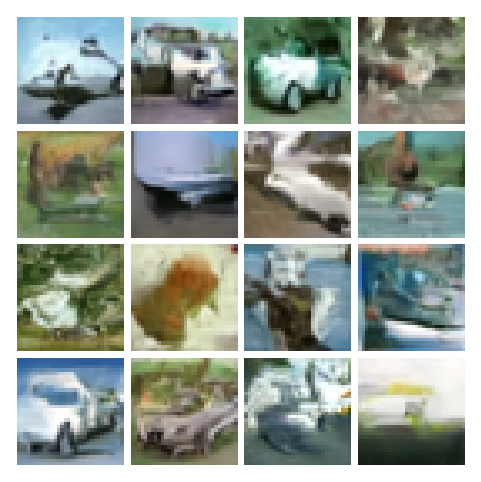

Epoch 61 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Epoch 61: Train Loss = 0.0316, Val Loss = 0.0307


Epoch 62 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.40it/s]


Epoch 62: Train Loss = 0.0313, Val Loss = 0.0313


Epoch 63 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 63: Train Loss = 0.0312, Val Loss = 0.0310


Epoch 64 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 64: Train Loss = 0.0314, Val Loss = 0.0297


Epoch 65 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 65: Train Loss = 0.0312, Val Loss = 0.0299


Epoch 66 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 66: Train Loss = 0.0313, Val Loss = 0.0309


Epoch 67 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 67: Train Loss = 0.0315, Val Loss = 0.0307


Epoch 68 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Epoch 68: Train Loss = 0.0318, Val Loss = 0.0311


Epoch 69 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.29it/s]


Epoch 69: Train Loss = 0.0312, Val Loss = 0.0310


Epoch 70 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


Epoch 70: Train Loss = 0.0311, Val Loss = 0.0299
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_70.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.70it/s]


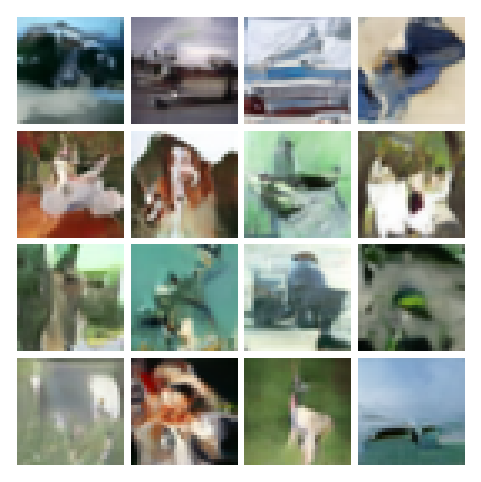

Epoch 71 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


Epoch 71: Train Loss = 0.0309, Val Loss = 0.0316


Epoch 72 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 72: Train Loss = 0.0314, Val Loss = 0.0310


Epoch 73 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s]


Epoch 73: Train Loss = 0.0313, Val Loss = 0.0296


Epoch 74 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 74: Train Loss = 0.0304, Val Loss = 0.0308


Epoch 75 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 75: Train Loss = 0.0309, Val Loss = 0.0304


Epoch 76 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 76: Train Loss = 0.0311, Val Loss = 0.0306


Epoch 77 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 77: Train Loss = 0.0310, Val Loss = 0.0305


Epoch 78 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 78: Train Loss = 0.0310, Val Loss = 0.0301


Epoch 79 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 79: Train Loss = 0.0307, Val Loss = 0.0306


Epoch 80 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 80: Train Loss = 0.0308, Val Loss = 0.0311
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_80.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.14it/s]


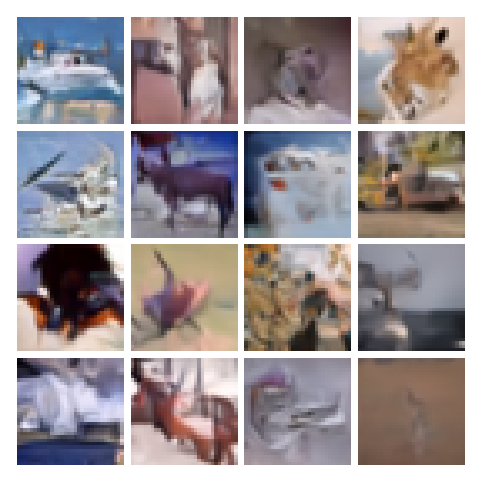

Epoch 81 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s]


Epoch 81: Train Loss = 0.0306, Val Loss = 0.0299


Epoch 82 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 82: Train Loss = 0.0308, Val Loss = 0.0309


Epoch 83 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 83: Train Loss = 0.0309, Val Loss = 0.0307


Epoch 84 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 84: Train Loss = 0.0309, Val Loss = 0.0308


Epoch 85 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 85: Train Loss = 0.0310, Val Loss = 0.0305


Epoch 86 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 86: Train Loss = 0.0309, Val Loss = 0.0299


Epoch 87 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 87: Train Loss = 0.0307, Val Loss = 0.0312


Epoch 88 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 88: Train Loss = 0.0305, Val Loss = 0.0307


Epoch 89 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 89: Train Loss = 0.0309, Val Loss = 0.0309


Epoch 90 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 90: Train Loss = 0.0313, Val Loss = 0.0301
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_90.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 65.25it/s]


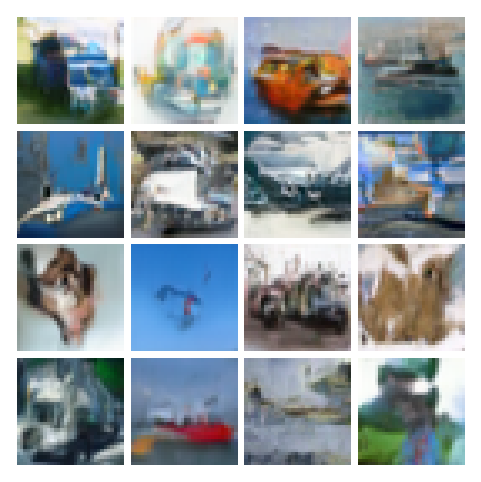

Epoch 91 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 91: Train Loss = 0.0302, Val Loss = 0.0310


Epoch 92 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Epoch 92: Train Loss = 0.0308, Val Loss = 0.0311


Epoch 93 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 93: Train Loss = 0.0305, Val Loss = 0.0309


Epoch 94 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s]


Epoch 94: Train Loss = 0.0312, Val Loss = 0.0294


Epoch 95 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 95: Train Loss = 0.0302, Val Loss = 0.0298


Epoch 96 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Epoch 96: Train Loss = 0.0312, Val Loss = 0.0307


Epoch 97 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 97: Train Loss = 0.0310, Val Loss = 0.0313


Epoch 98 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.30it/s]


Epoch 98: Train Loss = 0.0306, Val Loss = 0.0303


Epoch 99 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]


Epoch 99: Train Loss = 0.0303, Val Loss = 0.0311


Epoch 100 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.22it/s]


Epoch 100: Train Loss = 0.0306, Val Loss = 0.0311
Checkpoint saved to ./checkpoints/unconditional_ckpt_epoch_100.pt


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 64.15it/s]


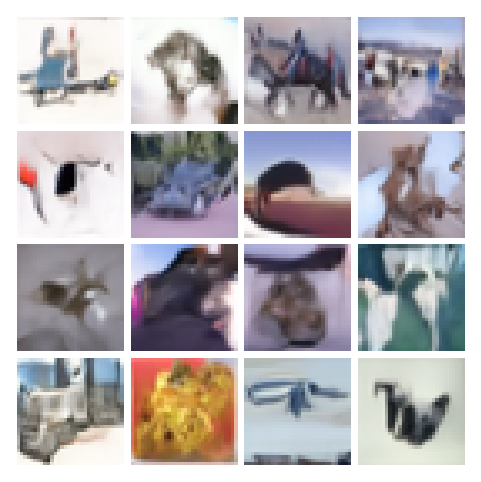

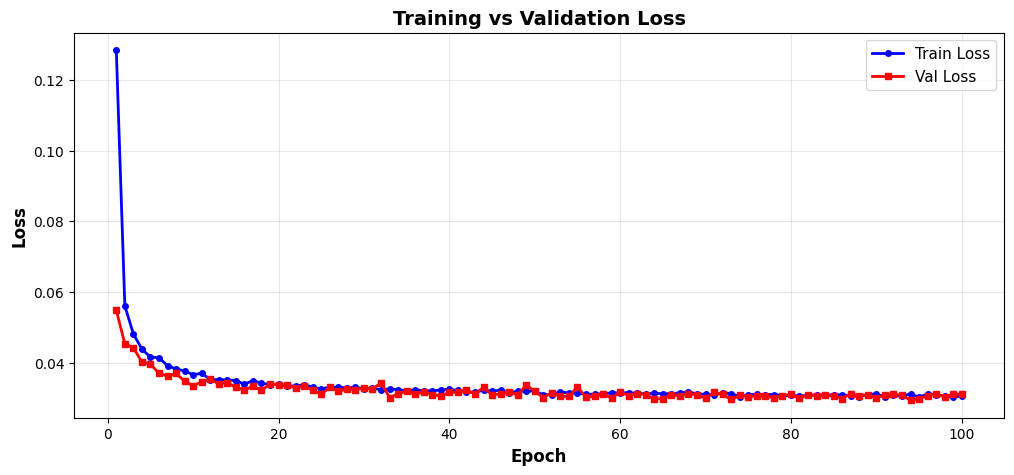


[4] Generating unconditional samples...


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 62.32it/s]


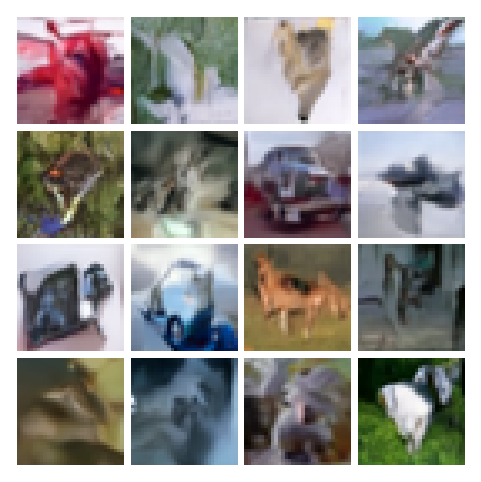


TRAINING CONDITIONAL MODEL

[5] Initializing conditional model...
Model Parameters: 24.4M

[6] Training conditional model...


Epoch 1 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Epoch 1: Train Loss = 0.1437, Val Loss = 0.0573


Epoch 2 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.30it/s]


Epoch 2: Train Loss = 0.0548, Val Loss = 0.0455


Epoch 3 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Epoch 3: Train Loss = 0.0478, Val Loss = 0.0416


Epoch 4 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 4: Train Loss = 0.0438, Val Loss = 0.0391


Epoch 5 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 5: Train Loss = 0.0420, Val Loss = 0.0361


Epoch 6 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 6: Train Loss = 0.0395, Val Loss = 0.0377


Epoch 7 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.29it/s]


Epoch 7: Train Loss = 0.0379, Val Loss = 0.0364


Epoch 8 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 8: Train Loss = 0.0375, Val Loss = 0.0354


Epoch 9 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


Epoch 9: Train Loss = 0.0367, Val Loss = 0.0363


Epoch 10 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Epoch 10: Train Loss = 0.0360, Val Loss = 0.0342
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_10.pt

Generating conditional samples for epoch 10...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]


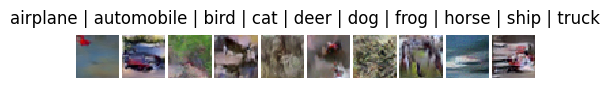

Epoch 11 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s]


Epoch 11: Train Loss = 0.0357, Val Loss = 0.0343


Epoch 12 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s]


Epoch 12: Train Loss = 0.0344, Val Loss = 0.0352


Epoch 13 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s]


Epoch 13: Train Loss = 0.0348, Val Loss = 0.0344


Epoch 14 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 14: Train Loss = 0.0342, Val Loss = 0.0336


Epoch 15 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s]


Epoch 15: Train Loss = 0.0344, Val Loss = 0.0332


Epoch 16 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 16: Train Loss = 0.0339, Val Loss = 0.0330


Epoch 17 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s]


Epoch 17: Train Loss = 0.0337, Val Loss = 0.0337


Epoch 18 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Epoch 18: Train Loss = 0.0339, Val Loss = 0.0320


Epoch 19 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s]


Epoch 19: Train Loss = 0.0334, Val Loss = 0.0324


Epoch 20 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s]


Epoch 20: Train Loss = 0.0337, Val Loss = 0.0328
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_20.pt

Generating conditional samples for epoch 20...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.46it/s]


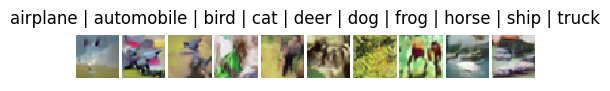

Epoch 21 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s]


Epoch 21: Train Loss = 0.0334, Val Loss = 0.0332


Epoch 22 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 22: Train Loss = 0.0333, Val Loss = 0.0341


Epoch 23 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 23: Train Loss = 0.0330, Val Loss = 0.0321


Epoch 24 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 24: Train Loss = 0.0325, Val Loss = 0.0317


Epoch 25 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 25: Train Loss = 0.0332, Val Loss = 0.0323


Epoch 26 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


Epoch 26: Train Loss = 0.0328, Val Loss = 0.0308


Epoch 27 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 27: Train Loss = 0.0328, Val Loss = 0.0311


Epoch 28 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.17it/s]


Epoch 28: Train Loss = 0.0324, Val Loss = 0.0327


Epoch 29 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 29: Train Loss = 0.0324, Val Loss = 0.0324


Epoch 30 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 30: Train Loss = 0.0320, Val Loss = 0.0310
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_30.pt

Generating conditional samples for epoch 30...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.22it/s]


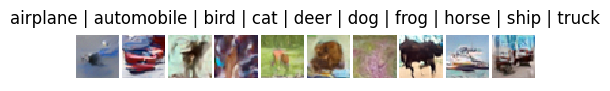

Epoch 31 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Epoch 31: Train Loss = 0.0324, Val Loss = 0.0319


Epoch 32 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Epoch 32: Train Loss = 0.0322, Val Loss = 0.0316


Epoch 33 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 33: Train Loss = 0.0317, Val Loss = 0.0319


Epoch 34 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 34: Train Loss = 0.0320, Val Loss = 0.0318


Epoch 35 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


Epoch 35: Train Loss = 0.0326, Val Loss = 0.0312


Epoch 36 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


Epoch 36: Train Loss = 0.0319, Val Loss = 0.0316


Epoch 37 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 37: Train Loss = 0.0321, Val Loss = 0.0325


Epoch 38 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s]


Epoch 38: Train Loss = 0.0314, Val Loss = 0.0331


Epoch 39 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 39: Train Loss = 0.0317, Val Loss = 0.0315


Epoch 40 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 40: Train Loss = 0.0315, Val Loss = 0.0319
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_40.pt

Generating conditional samples for epoch 40...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.09it/s]


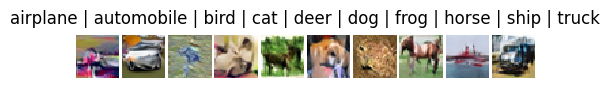

Epoch 41 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 41: Train Loss = 0.0320, Val Loss = 0.0309


Epoch 42 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 42: Train Loss = 0.0310, Val Loss = 0.0310


Epoch 43 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s]


Epoch 43: Train Loss = 0.0314, Val Loss = 0.0308


Epoch 44 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 44: Train Loss = 0.0318, Val Loss = 0.0316


Epoch 45 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 45: Train Loss = 0.0314, Val Loss = 0.0321


Epoch 46 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 46: Train Loss = 0.0318, Val Loss = 0.0317


Epoch 47 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s]


Epoch 47: Train Loss = 0.0316, Val Loss = 0.0312


Epoch 48 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 48: Train Loss = 0.0312, Val Loss = 0.0301


Epoch 49 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 49: Train Loss = 0.0317, Val Loss = 0.0309


Epoch 50 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 50: Train Loss = 0.0312, Val Loss = 0.0306
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_50.pt

Generating conditional samples for epoch 50...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.28it/s]


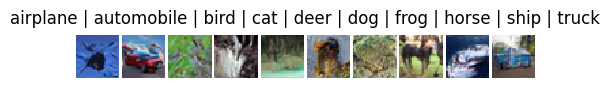

Epoch 51 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 51: Train Loss = 0.0311, Val Loss = 0.0320


Epoch 52 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Epoch 52: Train Loss = 0.0314, Val Loss = 0.0318


Epoch 53 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 53: Train Loss = 0.0311, Val Loss = 0.0316


Epoch 54 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 54: Train Loss = 0.0315, Val Loss = 0.0320


Epoch 55 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s]


Epoch 55: Train Loss = 0.0307, Val Loss = 0.0316


Epoch 56 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 56: Train Loss = 0.0304, Val Loss = 0.0311


Epoch 57 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 57: Train Loss = 0.0313, Val Loss = 0.0313


Epoch 58 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 58: Train Loss = 0.0311, Val Loss = 0.0306


Epoch 59 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.22it/s]


Epoch 59: Train Loss = 0.0311, Val Loss = 0.0316


Epoch 60 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.33it/s]


Epoch 60: Train Loss = 0.0311, Val Loss = 0.0314
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_60.pt

Generating conditional samples for epoch 60...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.34it/s]


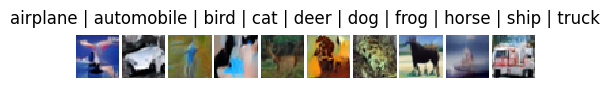

Epoch 61 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Epoch 61: Train Loss = 0.0307, Val Loss = 0.0307


Epoch 62 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 62: Train Loss = 0.0307, Val Loss = 0.0309


Epoch 63 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 63: Train Loss = 0.0310, Val Loss = 0.0314


Epoch 64 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 64: Train Loss = 0.0308, Val Loss = 0.0308


Epoch 65 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 65: Train Loss = 0.0307, Val Loss = 0.0321


Epoch 66 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]


Epoch 66: Train Loss = 0.0303, Val Loss = 0.0309


Epoch 67 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 67: Train Loss = 0.0313, Val Loss = 0.0310


Epoch 68 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 68: Train Loss = 0.0306, Val Loss = 0.0314


Epoch 69 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.09it/s]


Epoch 69: Train Loss = 0.0309, Val Loss = 0.0302


Epoch 70 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s]


Epoch 70: Train Loss = 0.0309, Val Loss = 0.0331
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_70.pt

Generating conditional samples for epoch 70...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.12it/s]


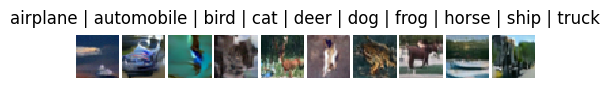

Epoch 71 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Epoch 71: Train Loss = 0.0306, Val Loss = 0.0317


Epoch 72 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]


Epoch 72: Train Loss = 0.0308, Val Loss = 0.0316


Epoch 73 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s]


Epoch 73: Train Loss = 0.0310, Val Loss = 0.0314


Epoch 74 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Epoch 74: Train Loss = 0.0304, Val Loss = 0.0298


Epoch 75 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Epoch 75: Train Loss = 0.0312, Val Loss = 0.0303


Epoch 76 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 76: Train Loss = 0.0307, Val Loss = 0.0302


Epoch 77 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s]


Epoch 77: Train Loss = 0.0305, Val Loss = 0.0307


Epoch 78 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.29it/s]


Epoch 78: Train Loss = 0.0307, Val Loss = 0.0292


Epoch 79 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 79: Train Loss = 0.0308, Val Loss = 0.0306


Epoch 80 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Epoch 80: Train Loss = 0.0315, Val Loss = 0.0301
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_80.pt

Generating conditional samples for epoch 80...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.48it/s]


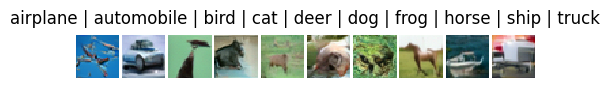

Epoch 81 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s]


Epoch 81: Train Loss = 0.0304, Val Loss = 0.0307


Epoch 82 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 82: Train Loss = 0.0308, Val Loss = 0.0311


Epoch 83 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 83: Train Loss = 0.0310, Val Loss = 0.0320


Epoch 84 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 84: Train Loss = 0.0313, Val Loss = 0.0306


Epoch 85 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 85: Train Loss = 0.0310, Val Loss = 0.0312


Epoch 86 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 86: Train Loss = 0.0303, Val Loss = 0.0307


Epoch 87 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 87: Train Loss = 0.0304, Val Loss = 0.0301


Epoch 88 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s]


Epoch 88: Train Loss = 0.0307, Val Loss = 0.0294


Epoch 89 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Epoch 89: Train Loss = 0.0312, Val Loss = 0.0296


Epoch 90 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 90: Train Loss = 0.0305, Val Loss = 0.0303
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_90.pt

Generating conditional samples for epoch 90...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.87it/s]


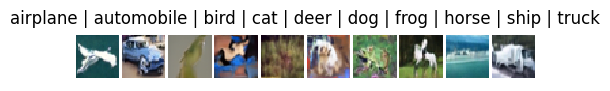

Epoch 91 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 91: Train Loss = 0.0310, Val Loss = 0.0304


Epoch 92 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 92: Train Loss = 0.0307, Val Loss = 0.0304


Epoch 93 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 93: Train Loss = 0.0305, Val Loss = 0.0291


Epoch 94 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.33it/s]


Epoch 94: Train Loss = 0.0303, Val Loss = 0.0300


Epoch 95 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.30it/s]


Epoch 95: Train Loss = 0.0307, Val Loss = 0.0299


Epoch 96 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 96: Train Loss = 0.0303, Val Loss = 0.0297


Epoch 97 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


Epoch 97: Train Loss = 0.0300, Val Loss = 0.0303


Epoch 98 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 98: Train Loss = 0.0307, Val Loss = 0.0308


Epoch 99 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 99: Train Loss = 0.0303, Val Loss = 0.0290


Epoch 100 Validation: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 100: Train Loss = 0.0303, Val Loss = 0.0309
Checkpoint saved to ./checkpoints_conditional/conditional_ckpt_epoch_100.pt

Generating conditional samples for epoch 100...


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]


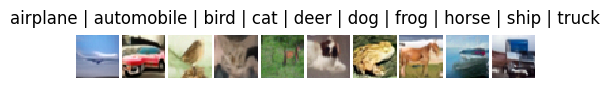

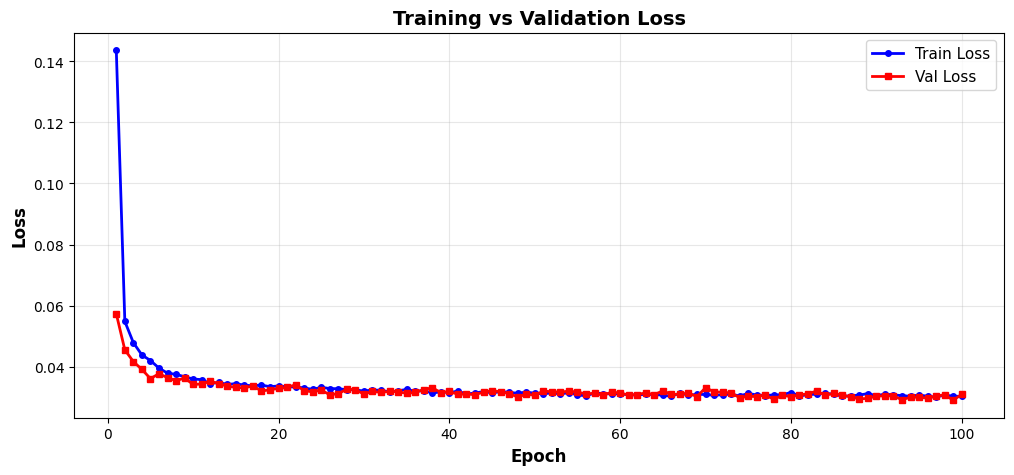


[7] Generating conditional samples...

Guidance Scale: 1.0

Guidance Scale: 3.0

Guidance Scale: 7.0


CFG Sampling: 100%|██████████| 50/50 [00:01<00:00, 31.95it/s]


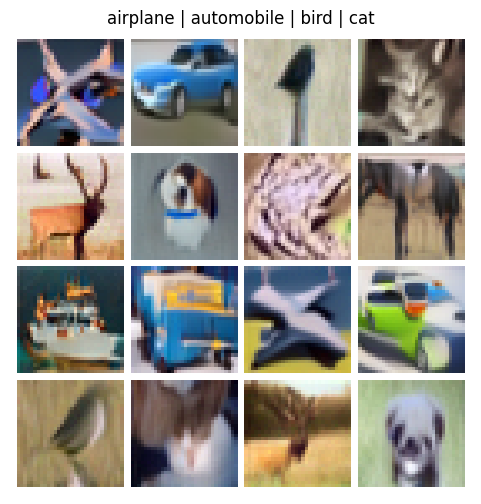

In [21]:
print("\n" + "=" * 80)
print("TRAINING UNCONDITIONAL MODEL")
print("=" * 80)

# Initialize unconditional model
print("\n[2] Initializing unconditional model...")
unconditional_model = UNet(
        in_channels=3,
        out_channels=3,
        base_channels=128,
        channel_mult=(1, 2, 2, 2),
        num_res_blocks=2,
        num_classes=None
).to(device)

num_params = sum(p.numel() for p in unconditional_model.parameters())
print(f"Model Parameters: {num_params / 1e6:.1f}M")

# Create diffusion instance
diffusion_unconditional = GaussianDiffusion(timesteps=1000, beta_schedule='linear', device=device)

# Train unconditional model
print("\n[3] Training unconditional model...")

unconditional_losses,val_unconditional_losses= train_unconditional(
        unconditional_model,
        diffusion_unconditional,
        train_dataloader,
        test_dataloader,
        num_epochs=100,
        lr=2e-4
    )

# Plot training loss
plot_training_losses(unconditional_losses,val_unconditional_losses)

# Generate samples
print("\n[4] Generating unconditional samples...")
unconditional_model.eval()
with torch.no_grad():
  samples = diffusion_unconditional.ddim_sample(unconditional_model, (16, 3, 32, 32),
                                                     ddim_timesteps=50)
  show_images(samples, nrow=4, save_path='./unconditional_samples.png')


print("\n" + "=" * 80)
print("TRAINING CONDITIONAL MODEL")
print("=" * 80)

# Initialize conditional model
print("\n[5] Initializing conditional model...")
conditional_model = UNet(
        in_channels=3,
        out_channels=3,
        base_channels=128,
        channel_mult=(1, 2, 2, 2),
        num_res_blocks=2,
        num_classes=10  # CIFAR-10 has 10 classes
    ).to(device)

num_params = sum(p.numel() for p in conditional_model.parameters())
print(f"Model Parameters: {num_params / 1e6:.1f}M")

# Create diffusion instance
diffusion_conditional = GaussianDiffusion(timesteps=1000, beta_schedule='linear', device=device)

# Train conditional model
print("\n[6] Training conditional model...")

conditional_losses,val_conditional_losses = train_conditional(
        conditional_model,
        diffusion_conditional,
        train_dataloader,
        test_dataloader,
        num_epochs=100,
        lr=2e-4,
        p_uncond=0.1
    )

# Plot training loss
plot_training_losses(conditional_losses,val_conditional_losses)

# Generate conditional samples
print("\n[7] Generating conditional samples...")
conditional_model.eval()

# Sample with different guidance scales
for guidance_scale in [1.0, 3.0, 7.0]:
  print(f"\nGuidance Scale: {guidance_scale}")
  y_sample = torch.arange(10, device=device).repeat(2)[:16]

with torch.no_grad():
  samples = sample_with_cfg(
                conditional_model,
                diffusion_conditional,
                (16, 3, 32, 32),
                y_sample,
                guidance_scale=guidance_scale
            )

  show_images(samples, y_sample, nrow=4)


In [ ]:
print("\n[8] Creating visualizations...")

sample_img, _ = next(iter(test_dataloader))
sample_img = sample_img[:1].to(device)
visualize_forward_diffusion(sample_img, diffusion_unconditional)
# Visualize reverse diffusion
unconditional_model.eval()
visualize_reverse_diffusion(unconditional_model, diffusion_unconditional,
                               (1, 3, 32, 32))
print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)

# Part 7: DQAR Integration - Attention Reuse for Faster Sampling

This section integrates **DQAR (Dynamic and Quantization-Aware Attention Reuse)** into the custom diffusion model to accelerate sampling by reusing attention outputs when the attention entropy is low (i.e., when attention patterns are stable across timesteps).

In [ ]:
# ============================================================================
# DQAR: Minimal Self-Contained Implementation
# Dynamic and Quantization-Aware Attention Reuse for Diffusion Transformers
# ============================================================================

from dataclasses import dataclass, field
from typing import Optional, Dict, Any, Set
import math

# ---------------------------------------------------------------------------
# Configuration Classes
# ---------------------------------------------------------------------------

@dataclass
class ReuseGateConfig:
    """Heuristics and thresholds for entropy-driven reuse."""
    entropy_threshold: float = 2.5
    snr_range: tuple = (0.1, 100.0)
    min_step: int = 0
    cooldown_steps: int = 0
    min_probability: float = 0.0
    eps: float = 1e-6

@dataclass
class SchedulerConfig:
    """Controls which layers are eligible for reuse."""
    max_reuse_per_block: int = 10
    max_gap: int = 10

@dataclass
class DQARConfig:
    """Top-level configuration for DQAR."""
    gate: ReuseGateConfig = field(default_factory=ReuseGateConfig)
    scheduler: SchedulerConfig = field(default_factory=SchedulerConfig)

# ---------------------------------------------------------------------------
# Cache Entry and Simple Controller
# ---------------------------------------------------------------------------

@dataclass
class CacheEntry:
    """Stores cached attention output and metrics."""
    layer_id: int
    branch: str
    step: int
    entropy: float
    reuse_count: int = 0
    _cached_output: Optional[torch.Tensor] = None

class DQARController:
    """
    Simplified DQAR controller for entropy-gated attention reuse.
    
    This minimal implementation provides:
    - Cache storage/lookup per layer
    - Entropy-based gating decisions  
    - Reuse counting for benchmarks
    """
    
    def __init__(self, num_layers: int, config: Optional[DQARConfig] = None):
        self.num_layers = num_layers
        self.config = config or DQARConfig()
        
        # Cache storage: layer_id -> CacheEntry
        self._cache: Dict[int, CacheEntry] = {}
        
        # Step state
        self.current_step = 0
        self.total_steps = 50
        self.prompt_length = 16
        
        # Counters
        self._total_reuse_count = 0
        self._total_compute_count = 0
    
    def begin_step(self, step_index: int, total_steps: int, prompt_length: int = 16):
        """Begin a new diffusion step."""
        self.current_step = step_index
        self.total_steps = total_steps
        self.prompt_length = prompt_length
    
    def try_reuse(self, layer_id: int, branch: str = "main") -> Optional[CacheEntry]:
        """
        Check if we can reuse cached attention for this layer.
        Returns CacheEntry if reuse is approved, None otherwise.
        """
        gate_cfg = self.config.gate
        sched_cfg = self.config.scheduler
        
        # Gate 1: Warmup check
        if self.current_step < gate_cfg.min_step:
            return None
        
        # Gate 2: Cache lookup
        entry = self._cache.get(layer_id)
        if entry is None:
            return None
        
        # Gate 3: Step gap check
        step_gap = self.current_step - entry.step
        if step_gap <= 0:
            return None
        if step_gap < gate_cfg.cooldown_steps:
            return None
        if step_gap > sched_cfg.max_gap:
            return None
        
        # Gate 4: Budget check
        if entry.reuse_count >= sched_cfg.max_reuse_per_block:
            return None
        
        # Gate 5: Entropy check
        if entry.entropy > gate_cfg.entropy_threshold:
            return None
        
        # All gates passed - approve reuse
        entry.reuse_count += 1
        self._total_reuse_count += 1
        return entry
    
    def commit(
        self,
        layer_id: int,
        branch: str,
        attn_map: Any,
        entropy: float,
        output_norm: float = 0.0,
    ) -> CacheEntry:
        """Store attention metrics in cache."""
        entry = CacheEntry(
            layer_id=layer_id,
            branch=branch,
            step=self.current_step,
            entropy=entropy,
            reuse_count=0,
        )
        self._cache[layer_id] = entry
        self._total_compute_count += 1
        return entry
    
    def get_reuse_count(self) -> int:
        """Get total number of reuse events."""
        return self._total_reuse_count
    
    def get_compute_count(self) -> int:
        """Get total number of fresh computations."""
        return self._total_compute_count
    
    def clear(self):
        """Clear cache and reset counters."""
        self._cache.clear()
        self._total_reuse_count = 0
        self._total_compute_count = 0

# Count attention layers in UNet
def count_attention_layers(model):
    """Count AttentionBlock layers in the UNet."""
    count = 0
    for module in model.modules():
        if isinstance(module, AttentionBlock):
            count += 1
    return count

num_attn_layers = count_attention_layers(unconditional_model)
print(f"Found {num_attn_layers} AttentionBlock layers in UNet")
print("DQAR classes defined (self-contained, no external imports needed)")

In [ ]:
class DQARAttentionWrapper(nn.Module):
    """
    Wrapper for AttentionBlock that integrates DQAR attention reuse.
    Captures real attention weights and caches outputs for reuse.
    """
    def __init__(self, attention_block: AttentionBlock, layer_idx: int):
        super().__init__()
        self.attention_block = attention_block
        self.layer_idx = layer_idx
        self.controller = None
        self._cached_output = None
        
    def set_controller(self, controller: DQARController):
        self.controller = controller
        
    def forward(self, x):
        # If no controller, just run original attention
        if self.controller is None:
            return self.attention_block(x)
        
        # Check if we can reuse cached attention
        entry = self.controller.try_reuse(layer_id=self.layer_idx, branch="main")
        if entry is not None and hasattr(entry, '_cached_output') and entry._cached_output is not None:
            # Reuse cached output
            return entry._cached_output
        
        # Compute attention with weight capture
        output, attn_probs = self._forward_with_weights(x)
        
        # Compute entropy for DQAR gating
        # attn_probs shape: (batch, heads, seq, seq)
        entropy = self._compute_entropy(attn_probs)
        
        # Commit to controller cache
        attn_list = [attn_probs[i].detach().cpu() for i in range(attn_probs.shape[0])]
        entry = self.controller.commit(
            layer_id=self.layer_idx,
            branch="main",
            attn_map=attn_list,
            entropy=entropy,
            output_norm=output.norm().item(),
        )
        # Cache the full output for reuse
        entry._cached_output = output.detach().clone()
        
        return output
    
    def _forward_with_weights(self, x):
        """Forward pass that returns both output and attention weights."""
        attn = self.attention_block
        shortcut = x
        h_spatial, w_spatial = x.shape[-2:]
        
        normed_x = attn.norm(x)
        qkv = attn.to_qkv(normed_x).chunk(3, dim=1)
        
        # Rearrange for multi-head attention
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h=attn.num_heads), qkv)
        
        # Compute attention scores and weights
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * attn.scale
        attn_probs = dots.softmax(dim=-1)  # Real attention weights!
        
        # Apply attention to values
        out = torch.einsum('b h i j, b h j d -> b h i d', attn_probs, v)
        
        # Rearrange back
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h_spatial, y=w_spatial)
        out = attn.to_out(out)
        
        return out + shortcut, attn_probs
    
    def _compute_entropy(self, attn_probs):
        """Compute attention entropy (averaged across batch and heads)."""
        # attn_probs: (batch, heads, seq, seq)
        # Entropy per attention distribution
        eps = 1e-8
        entropy = -torch.sum(attn_probs * torch.log(attn_probs + eps), dim=-1)
        # Average across batch, heads, and query positions
        return entropy.mean().item()


def wrap_unet_attention_layers(model: UNet, start_idx: int = 0):
    """
    Wrap all AttentionBlock layers in a UNet with DQARAttentionWrapper.
    Returns the wrapped model and list of wrappers.
    """
    wrappers = []
    layer_idx = start_idx
    
    # Wrap attention in downs
    for i, layer in enumerate(model.downs):
        if isinstance(layer, AttentionBlock):
            wrapper = DQARAttentionWrapper(layer, layer_idx)
            model.downs[i] = wrapper
            wrappers.append(wrapper)
            layer_idx += 1
    
    # Wrap middle attention
    if isinstance(model.mid_attn, AttentionBlock):
        wrapper = DQARAttentionWrapper(model.mid_attn, layer_idx)
        model.mid_attn = wrapper
        wrappers.append(wrapper)
        layer_idx += 1
    
    # Wrap attention in ups
    for i, layer in enumerate(model.ups):
        if isinstance(layer, AttentionBlock):
            wrapper = DQARAttentionWrapper(layer, layer_idx)
            model.ups[i] = wrapper
            wrappers.append(wrapper)
            layer_idx += 1
    
    return model, wrappers

print("DQARAttentionWrapper defined successfully")

In [ ]:
@torch.no_grad()
def ddim_sample_with_dqar(model, diffusion, shape, wrappers, controller, y=None, ddim_timesteps=50, eta=0.0):
    """
    DDIM sampling with DQAR attention reuse.
    
    Args:
        model: UNet model with wrapped attention layers
        diffusion: GaussianDiffusion instance
        shape: Output shape (batch, channels, height, width)
        wrappers: List of DQARAttentionWrapper instances
        controller: DQARController instance
        y: Optional class labels for conditional generation
        ddim_timesteps: Number of DDIM steps
        eta: DDIM stochasticity parameter (0 = deterministic)
    """
    device = next(model.parameters()).device
    b = shape[0]
    
    # Set controller on all wrappers
    for wrapper in wrappers:
        wrapper.set_controller(controller)
    
    # DDIM timestep schedule
    c = diffusion.timesteps // ddim_timesteps
    ddim_timestep_seq = np.asarray(list(range(0, diffusion.timesteps, c)))
    ddim_timestep_seq = ddim_timestep_seq + 1
    ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
    
    img = torch.randn(shape, device=device)
    
    for i in tqdm(reversed(range(0, ddim_timesteps)), desc='DQAR DDIM Sampling', total=ddim_timesteps):
        t = torch.full((b,), ddim_timestep_seq[i], device=device, dtype=torch.long)
        prev_t = torch.full((b,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
        
        # Begin step in controller
        controller.begin_step(
            step_index=ddim_timesteps - 1 - i,
            total_steps=ddim_timesteps,
            prompt_length=shape[2] * shape[3],  # spatial dimension
        )
        
        # Predict noise using model (attention layers will use controller)
        pred_noise = model(img, t, y)
        
        # Calculate x_0 prediction
        alpha_cumprod_t = diffusion.extract(diffusion.alphas_cumprod, t, img.shape)
        sqrt_one_minus_alphas_cumprod_t = diffusion.extract(diffusion.sqrt_one_minus_alphas_cumprod, t, img.shape)
        pred_x0 = (img - sqrt_one_minus_alphas_cumprod_t * pred_noise) / torch.sqrt(alpha_cumprod_t)
        pred_x0.clamp_(-1., 1.)
        
        # Calculate x_{prev_t} for DDIM
        alpha_cumprod_prev_t = diffusion.extract(diffusion.alphas_cumprod, prev_t, img.shape)
        
        variance = diffusion.betas[t[0]] * (1. - alpha_cumprod_prev_t) / (1. - alpha_cumprod_t)
        std_dev_t = eta * torch.sqrt(variance)
        
        mean_x_t_minus_1 = torch.sqrt(alpha_cumprod_prev_t) * pred_x0
        if prev_t[0] > 0:
            mean_x_t_minus_1 += torch.sqrt(1. - alpha_cumprod_prev_t - std_dev_t**2) * pred_noise
        
        img = mean_x_t_minus_1 + std_dev_t * torch.randn_like(img) if prev_t[0] > 0 else mean_x_t_minus_1
    
    # Clear controller from wrappers
    for wrapper in wrappers:
        wrapper.set_controller(None)
    
    return img

print("DQAR DDIM sampling function defined")

In [ ]:
# Helper functions to create DQAR configurations
def make_baseline_config():
    """Config that prevents ALL reuse (true baseline)."""
    cfg = DQARConfig()
    cfg.gate.min_step = 9999  # Never start reusing
    cfg.gate.entropy_threshold = 0.0  # Impossible threshold
    cfg.scheduler.max_gap = 0
    cfg.scheduler.max_reuse_per_block = 0
    return cfg

def make_static_config():
    """Config that always reuses if cached."""
    cfg = DQARConfig()
    cfg.gate.min_step = 0
    cfg.gate.entropy_threshold = 1e9  # Always pass entropy check
    cfg.gate.cooldown_steps = 0
    cfg.scheduler.max_gap = 50
    cfg.scheduler.max_reuse_per_block = 50
    return cfg

def make_dqar_config(entropy_threshold=3.0):
    """Config with entropy-gated reuse."""
    cfg = DQARConfig()
    cfg.gate.min_step = 0
    cfg.gate.entropy_threshold = entropy_threshold
    cfg.gate.cooldown_steps = 0
    cfg.scheduler.max_gap = 10
    cfg.scheduler.max_reuse_per_block = 10
    return cfg

print("DQAR config helpers defined")

In [ ]:
# Wrap the trained unconditional model with DQAR attention wrappers
print("Wrapping UNet attention layers with DQAR...")

# Make a copy of the model for DQAR testing (to preserve original)
import copy
dqar_model = copy.deepcopy(unconditional_model)
dqar_model, wrappers = wrap_unet_attention_layers(dqar_model)
num_layers = len(wrappers)

print(f"Wrapped {num_layers} attention layers")
dqar_model.eval()

In [ ]:
import time

def benchmark_dqar(model, diffusion, wrappers, config, shape, ddim_timesteps=50, num_runs=3, seed=42):
    """Benchmark DQAR configuration."""
    times = []
    reuse_counts = []
    
    for run in range(num_runs):
        controller = DQARController(num_layers=len(wrappers), config=config)
        
        # Set seed for reproducibility
        torch.manual_seed(seed + run)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed + run)
            torch.cuda.synchronize()
        
        start = time.perf_counter()
        
        output = ddim_sample_with_dqar(
            model, diffusion, shape, wrappers, controller,
            ddim_timesteps=ddim_timesteps
        )
        
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.perf_counter() - start
        
        times.append(elapsed)
        reuse_counts.append(controller.get_reuse_count())
        print(f"  Run {run+1}: {elapsed:.2f}s, reuse={controller.get_reuse_count()}")
    
    return {
        "avg_time": np.mean(times),
        "std_time": np.std(times),
        "avg_reuse": np.mean(reuse_counts),
        "std_reuse": np.std(reuse_counts),
        "image": output,
    }

print("Benchmark function defined")

In [ ]:
# Run DQAR benchmarks
print("=" * 60)
print("DQAR BENCHMARK: Custom UNet on CIFAR-10")
print("=" * 60)

shape = (4, 3, 32, 32)  # 4 images
ddim_steps = 50
num_runs = 3

print("\n" + "=" * 50)
print("BASELINE (no reuse)")
print("=" * 50)
baseline = benchmark_dqar(dqar_model, diffusion_unconditional, wrappers, 
                          make_baseline_config(), shape, ddim_steps, num_runs)

print("\n" + "=" * 50)
print("STATIC (always reuse)")
print("=" * 50)
static = benchmark_dqar(dqar_model, diffusion_unconditional, wrappers,
                        make_static_config(), shape, ddim_steps, num_runs)

print("\n" + "=" * 50)
print("DQAR (entropy threshold=3.0)")
print("=" * 50)
dqar_3 = benchmark_dqar(dqar_model, diffusion_unconditional, wrappers,
                        make_dqar_config(3.0), shape, ddim_steps, num_runs)

print("\n" + "=" * 50)
print("DQAR (entropy threshold=4.0)")
print("=" * 50)
dqar_4 = benchmark_dqar(dqar_model, diffusion_unconditional, wrappers,
                        make_dqar_config(4.0), shape, ddim_steps, num_runs)

print("\n" + "=" * 50)
print("DQAR (entropy threshold=5.0)")
print("=" * 50)
dqar_5 = benchmark_dqar(dqar_model, diffusion_unconditional, wrappers,
                        make_dqar_config(5.0), shape, ddim_steps, num_runs)

In [ ]:
# Print summary table
print("\n" + "=" * 70)
print("DQAR BENCHMARK SUMMARY")
print("=" * 70)
print(f"{'Config':<20} {'Time (s)':<15} {'Reuse Events':<15} {'Speedup':<10}")
print("-" * 70)
print(f"{'Baseline':<20} {baseline['avg_time']:.2f} ± {baseline['std_time']:.2f}   {baseline['avg_reuse']:.0f}             1.00x")
print(f"{'Static':<20} {static['avg_time']:.2f} ± {static['std_time']:.2f}   {static['avg_reuse']:.0f}           {baseline['avg_time']/static['avg_time']:.2f}x")
print(f"{'DQAR τ=3.0':<20} {dqar_3['avg_time']:.2f} ± {dqar_3['std_time']:.2f}   {dqar_3['avg_reuse']:.0f}           {baseline['avg_time']/dqar_3['avg_time']:.2f}x")
print(f"{'DQAR τ=4.0':<20} {dqar_4['avg_time']:.2f} ± {dqar_4['std_time']:.2f}   {dqar_4['avg_reuse']:.0f}           {baseline['avg_time']/dqar_4['avg_time']:.2f}x")
print(f"{'DQAR τ=5.0':<20} {dqar_5['avg_time']:.2f} ± {dqar_5['std_time']:.2f}   {dqar_5['avg_reuse']:.0f}           {baseline['avg_time']/dqar_5['avg_time']:.2f}x")
print("=" * 70)

In [ ]:
# Plot benchmark results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

configs = ['Baseline', 'Static', 'DQAR\nτ=3.0', 'DQAR\nτ=4.0', 'DQAR\nτ=5.0']
times = [baseline['avg_time'], static['avg_time'], dqar_3['avg_time'], dqar_4['avg_time'], dqar_5['avg_time']]
time_errs = [baseline['std_time'], static['std_time'], dqar_3['std_time'], dqar_4['std_time'], dqar_5['std_time']]
reuse = [baseline['avg_reuse'], static['avg_reuse'], dqar_3['avg_reuse'], dqar_4['avg_reuse'], dqar_5['avg_reuse']]

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
x = np.arange(len(configs))

# Plot 1: Inference Time
bars1 = axes[0].bar(x, times, yerr=time_errs, capsize=5, color=colors)
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Inference Time (50 DDIM steps)', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(configs)
axes[0].bar_label(bars1, fmt='%.2f')

# Plot 2: Reuse Events
bars2 = axes[1].bar(x, reuse, color=colors)
axes[1].set_ylabel('Reuse Events', fontsize=12)
axes[1].set_title('Attention Reuse Count', fontsize=13)
axes[1].set_xticks(x)
axes[1].set_xticklabels(configs)
axes[1].bar_label(bars2, fmt='%.0f')

fig.suptitle('DQAR Benchmark: Custom UNet on CIFAR-10', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dqar_hw4_benchmark.png', dpi=150)
plt.show()

In [ ]:
# Visual comparison: Baseline vs DQAR samples
print("Generating comparison samples...")

# Generate baseline samples (no reuse)
torch.manual_seed(42)
controller_base = DQARController(num_layers=num_layers, config=make_baseline_config())
img_baseline = ddim_sample_with_dqar(
    dqar_model, diffusion_unconditional, (8, 3, 32, 32), wrappers, controller_base,
    ddim_timesteps=50
)
print(f"Baseline reuse count: {controller_base.get_reuse_count()}")

# Generate DQAR samples (same seed for fair comparison)
torch.manual_seed(42)
controller_dqar = DQARController(num_layers=num_layers, config=make_dqar_config(4.0))
img_dqar = ddim_sample_with_dqar(
    dqar_model, diffusion_unconditional, (8, 3, 32, 32), wrappers, controller_dqar,
    ddim_timesteps=50
)
print(f"DQAR reuse count: {controller_dqar.get_reuse_count()}")

# Display side by side
fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i in range(8):
    # Baseline row
    img = img_baseline[i].cpu() * 0.5 + 0.5
    img = torch.clamp(img, 0, 1)
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Baseline', fontsize=12, fontweight='bold')
    
    # DQAR row
    img = img_dqar[i].cpu() * 0.5 + 0.5
    img = torch.clamp(img, 0, 1)
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title(f'DQAR τ=4.0', fontsize=12, fontweight='bold')

fig.suptitle(f'Sample Comparison: Baseline (reuse=0) vs DQAR (reuse={controller_dqar.get_reuse_count()})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dqar_hw4_comparison.png', dpi=150)
plt.show()

print("\nDQAR integration complete!")

In [ ]:
# Entropy threshold sweep
print("Running entropy threshold sweep...")
thresholds = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0]
sweep_results = []

for thresh in thresholds:
    config = make_dqar_config(thresh)
    controller = DQARController(num_layers=num_layers, config=config)
    
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start = time.perf_counter()
    output = ddim_sample_with_dqar(
        dqar_model, diffusion_unconditional, (4, 3, 32, 32), wrappers, controller,
        ddim_timesteps=50
    )
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.perf_counter() - start
    
    sweep_results.append({
        "threshold": thresh,
        "time": elapsed,
        "reuse": controller.get_reuse_count(),
    })
    print(f"τ={thresh:.1f}: time={elapsed:.2f}s, reuse={controller.get_reuse_count()}")

# Plot sweep results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

threshs = [r['threshold'] for r in sweep_results]
times = [r['time'] for r in sweep_results]
reuses = [r['reuse'] for r in sweep_results]

axes[0].plot(threshs, reuses, 'o-', color='#C44E52', linewidth=2, markersize=8, label='DQAR')
axes[0].axhline(y=baseline['avg_reuse'], color='#4C72B0', linestyle='--', label='Baseline')
axes[0].set_xlabel('Entropy Threshold', fontsize=12)
axes[0].set_ylabel('Reuse Events', fontsize=12)
axes[0].set_title('Threshold vs Reuse Count', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(threshs, times, 'o-', color='#C44E52', linewidth=2, markersize=8, label='DQAR')
axes[1].axhline(y=baseline['avg_time'], color='#4C72B0', linestyle='--', label='Baseline')
axes[1].set_xlabel('Entropy Threshold', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Threshold vs Inference Time', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

fig.suptitle('DQAR Entropy Threshold Sweep (Custom UNet)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dqar_hw4_sweep.png', dpi=150)
plt.show()